In [1]:
import pandas as pd

# original dataframes from MediaCloud
df = pd.read_csv('../../Downloads/mc-onlinenews-mediacloud-20230609125302-content.csv.csv')
df_fox = pd.read_csv('../../Downloads/mc-onlinenews-mediacloud-20230701174438-content.csv.csv')

In [62]:
# scraping Fox News articles (already done - no need to redo)
from newspaper import Article
import pickle

fox_article_text = []
for url, ts in zip(df_fox['guidnea'].tolist(), df_fox['publish_date'].tolist()):
    try:
        article = Article(url)
        article.download()
        article.parse()
        txt = article.text
        fox_article_text.append((ts, txt))
    except Exception as e:
        print(e)
pickle.dump(fox_article_text, open('fox_may23_articles.pkl', 'wb'))

Article `download()` failed with ('Connection aborted.', OSError(22, 'Invalid argument')) on URL https://www.foxnews.com/sports/trans-runner-barred-olympics-rips-world-athletics-decision-maintain-fairness-womens-sports
Article `download()` failed with ('Connection aborted.', OSError(22, 'Invalid argument')) on URL https://www.foxnews.com/media/actress-marcia-gay-harden-attacks-lgbtq-laws-revealing-children-queer
Article `download()` failed with HTTPSConnectionPool(host='www.foxnews.com', port=443): Max retries exceeded with url: /politics/gop-governors-call-biden-admin-ditch-proposed-title-ix-regulations-protect-female-sports (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x15a965c40>, 'Connection to www.foxnews.com timed out. (connect timeout=7)')) on URL https://www.foxnews.com/politics/gop-governors-call-biden-admin-ditch-proposed-title-ix-regulations-protect-female-sports
Article `download()` failed with ('Connection aborted.', OSError(22, 'Invalid arg

In [63]:
# scraping florida state news articles (already done - no need to redo)
from newspaper import Article
article_text = []
for url, ts in zip(df['guid'].tolist(), df['publish_date'].tolist()):
    try:
        article = Article(url)
        article.download()
        article.parse()
        txt = article.text
        article_text.append((ts, txt))
    except Exception as e:
        print(e)
pickle.dump(article_text, open('article_text_may_2023_transgender_media_cloud_florida.pkl', 'wb'))

In [4]:
# scraping NYT articles (already done - no need to redo)
import datetime as dt
from pynytimes import NYTAPI
nyt = NYTAPI("ffESklDe64kqNGJg9MAE5TS5RW68izZT", parse_dates=True)
s = nyt.article_search(query='transgender', 
    dates={
        'begin': dt.datetime(year=2023, month=5, day=1),
        'end': dt.datetime(year=2023, month=5, day=31),
    }, 
    options=None, 
    results=1000
)

article_text_nyt = []
for url in [item['web_url'] for item in s]:
    try:
        article = Article(url)
        article.download()
        article.parse()
        txt = article.text
        article_text_nyt.append(txt)
    except Exception as e:
        print(e)
pickle.dump(s, open('nyt_may2023_trans_news_from_api.pkl', 'wb'))

/usr/local/lib/python3.9/site-packages/pynytimes/helpers/article_search.py:33: UserWarning: Asking for a lot of results, because of rate limits it can take a while.
  warnings.warn(


In [1]:
# loading pickles - start here. these exist already!
import pickle
article_text_data = pickle.load(open('./pickles/article_text_may_2023_transgender_media_cloud_florida.pkl', 'rb'))
tuples_nyt = pickle.load(open('./pickles/tuples_nyt_may.pkl', 'rb'))
fox_article_text = pickle.load(open('./pickles/fox_may23_articles.pkl', 'rb'))

In [86]:
# keyword extraction for fla articles
from rake_nltk import Rake
def get_dated_keywords(ts_text_tuples, min_length=1, max_length=2):
    """
    Given ts_text_tuples, a list of (timestamp, article_text) tuples,
    extract & return a list of timestamped keywords + scores using rake-nltk. 
    """
    dated_keywords = []
    r = Rake(min_length=min_length, max_length=max_length)
    for tup in ts_text_tuples:
        r.extract_keywords_from_text(tup[1])
        kw = r.get_ranked_phrases_with_scores()
        dated_keywords.append((tup[0], kw))
    
    return dated_keywords

nyt_dated_keywords = sorted(get_dated_keywords(tuples_nyt), key=lambda b: b[0])
fox_dated_keywords = get_dated_keywords(fox_article_text)
fl_dated_keywords = get_dated_keywords(article_text_data)

In [87]:
import numpy as np
import pytz

def df_causal_compare(kw_1, kw_2, normalize=True, log_scale=False):
    """
    Look at the flow of keywords from kw_1's articles to kw_2's articles. 
    Combine the scores of all keywords that article i in kw_1 has in common with article j in kw_2. 
    The entry [i, j] in the resulting matrix will be the log of the sum of their scores.
    We put a zero entry if article i happened after article j.
    """
    idx_1 = 0
    idx_2 = 0
    mtx_res = np.zeros((len(kw_1), len(kw_2)))
    mtx_mask = np.zeros((len(kw_1), len(kw_2)))
    for kw_2_ts, kw_2_list in kw_2:
        if idx_2 % 50 == 0:
            print(idx_2 / len(kw_2))
        score_mapping_2 = {kw[1]: kw[0] for kw in kw_2_list}
        kw_2_keywords = set([kw[1] for kw in kw_2_list])
        idx_1 = 0
        for kw_1_ts, kw_1_list in kw_1:
            kw_1_keywords = set([kw[1] for kw in kw_1_list])
            kw_overlap = kw_2_keywords.intersection(kw_1_keywords)
            score_mapping_1 = {kw[1]: kw[0] for kw in kw_1_list}
            try:
                localized_1 = pd.to_datetime(kw_1_ts).tz_localize(tz='UTC')
            except TypeError:
                localized_1 = pd.to_datetime(kw_1_ts)
            try:
                localized_2 = pd.to_datetime(kw_2_ts).tz_localize(tz='UTC')
            except TypeError:
                localized_2 = pd.to_datetime(kw_2_ts)
            if  localized_2 > localized_1:
                mtx_mask[idx_1, idx_2] = 1
                overlap_scores = [score_mapping_2[kw] for kw in list(kw_overlap)]
                if normalize:
                    tot_keyword_scores = sum([v for v in score_mapping_2.values()])
                else:
                    tot_keyword_scores = 1
                if log_scale:
                    mtx_res[idx_1, idx_2] = np.log(0.01 + (sum(overlap_scores) / tot_keyword_scores))
                else:
                    mtx_res[idx_1, idx_2] = 0.00001 + (sum(overlap_scores) / tot_keyword_scores)
            else:
                overlap_scores = [score_mapping_1[kw] for kw in list(kw_overlap)]
                if normalize:
                    tot_keyword_scores = sum([v for v in score_mapping_1.values()])
                else:
                    tot_keyword_scores = 1
                if log_scale:
                    mtx_res[idx_1, idx_2] = np.log(0.01 + (sum(overlap_scores) / tot_keyword_scores))
                else:
                    mtx_res[idx_1, idx_2] = 0.00001 + (sum(overlap_scores) / tot_keyword_scores)
                    
            idx_1 += 1
        idx_2 += 1
    return mtx_res, mtx_mask

In [88]:
import pandas as pd
mtx_fox_fla, mask_fox_fla = df_causal_compare(fox_dated_keywords, fl_dated_keywords)
mtx_nyt_fla, mask_nyt_fla = df_causal_compare(nyt_dated_keywords, fl_dated_keywords)
# mtx_nyt_fox = df_causal_compare(nyt_dated_keywords, fox_dated_keywords)
# mtx_fla_fla = df_causal_compare(fl_dated_keywords, fl_dated_keywords)

0.0
0.04351610095735422
0.08703220191470844
0.13054830287206268
0.17406440382941687
0.2175805047867711
0.26109660574412535
0.30461270670147955
0.34812880765883375
0.391644908616188
0.4351610095735422
0.47867711053089645
0.5221932114882507
0.5657093124456049
0.6092254134029591
0.6527415143603134
0.6962576153176675
0.7397737162750218
0.783289817232376
0.8268059181897301
0.8703220191470844
0.9138381201044387
0.9573542210617929
0.0
0.04351610095735422
0.08703220191470844
0.13054830287206268
0.17406440382941687
0.2175805047867711
0.26109660574412535
0.30461270670147955
0.34812880765883375
0.391644908616188
0.4351610095735422
0.47867711053089645
0.5221932114882507
0.5657093124456049
0.6092254134029591
0.6527415143603134
0.6962576153176675
0.7397737162750218
0.783289817232376
0.8268059181897301
0.8703220191470844
0.9138381201044387
0.9573542210617929


<AxesSubplot:title={'center':'NYT/FL local shared keywords, normalized, token length between 1 and 2'}>

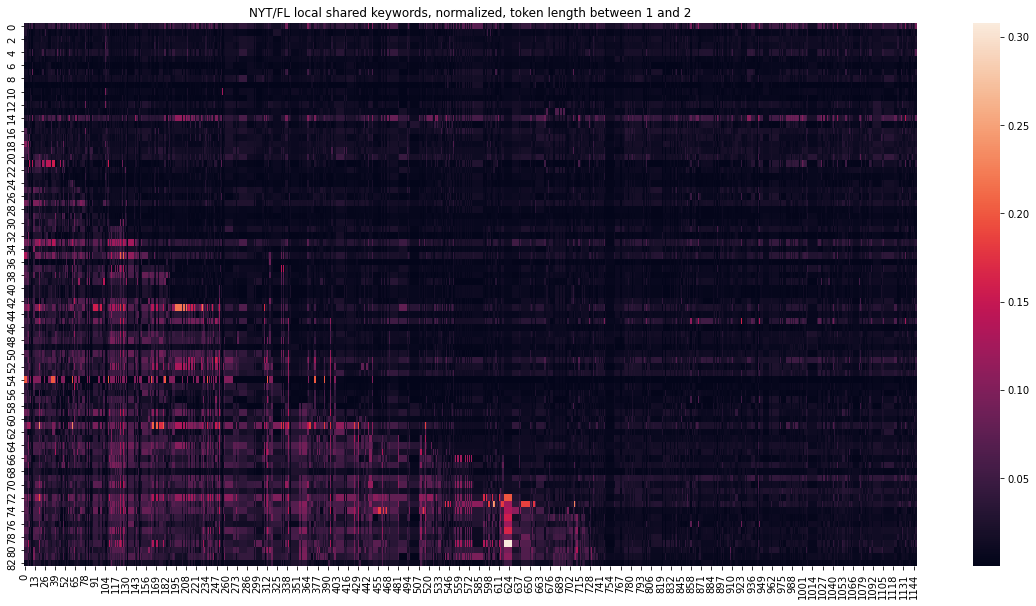

In [89]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
plt.title('NYT/FL local shared keywords, normalized, token length between 1 and 2')
plt.xlabel('FL local articles')
plt.ylabel('NYT articles')
sns.heatmap(mtx_nyt_fla)


In [90]:
print('how much did each NYT/Fox article influence all future FL articles, on average?')
print(
    np.mean(np.sum(mtx_nyt_fla, axis=1, where=mask_nyt_fla.astype(bool)) / np.sum(mask_nyt_fla)), 
    np.mean(np.sum(mtx_fox_fla, axis=1, where=mask_fox_fla.astype(bool)) / np.sum(mask_fox_fla))
)
print('how much was each NYT/Fox article influenced by all previous FL articles, on average?')
print(
    np.mean(np.sum(mtx_nyt_fla, axis=1, where=np.logical_not(mask_nyt_fla.astype(bool))) / np.sum(np.logical_not(mask_nyt_fla))), 
    np.mean(np.sum(mtx_fox_fla, axis=1, where=np.logical_not(mask_fox_fla.astype(bool))) / np.sum(np.logical_not(mask_fox_fla)))
)

how much did each NYT/Fox article influence all future FL articles, on average?
0.00014643880991079778 3.696224476502005e-05
how much was each NYT/Fox article influenced by all previous FL articles, on average?
0.00046703025548896273 5.599961389022177e-05


In [166]:
import networkx as nx
nyt_fl = nx.Graph()
for i_nyt in range(len(nyt_dated_keywords)):
    nyt_fl.add_node('nyt_' + str(i_nyt), bipartite=0)
    for j_fl in range(len(fl_dated_keywords)):
        if i_nyt == 0:
            nyt_fl.add_node('fla_' + str(j_fl), bipartite=1)
        nyt_fl.add_edges_from([(
            'nyt_' + str(i_nyt), 
            'fla_' + str(j_fl), 
            {'weight': mtx_nyt_fla[i_nyt, j_fl]}
        )])

In [167]:
import collections
pruned_nyt_fl = nx.Graph()
pruned_nyt_fl.add_nodes_from(nyt_fl.nodes())
pruned_nyt_fl.add_edges_from([(u, v, e) for u,v,e in nyt_fl.edges(data=True) if e['weight'] >= 3.5])

for cc in nx.connected_components(pruned_nyt_fl):
    if len(cc) > 1:
        tot_overlap = collections.Counter()
        seen_ts = set()
        for node in list(cc):
            if 'nyt_' in node:
                tot_overlap += {k[1]: len(cc) for k in nyt_dated_keywords[int(node[4:])][1]}
            elif 'fla' in node:
                if fl_dated_keywords[int(node[4:])][0] not in seen_ts:
                    seen_ts.add(fl_dated_keywords[int(node[4:])][0])
                    tot_overlap += {k[1]: 1 for k in fl_dated_keywords[int(node[4:])][1]}
        print({phrase: count - len(cc) for phrase, count in tot_overlap.items() if count > len(cc)})

{'celebrate pride month': 6, 'including removing items': 5, 'transgender rights': 9, 'women ’': 428, 'state ’': 1291, 'bud light': 5, ',”': 443, 'transgender minors': 869, '“ standing': 4, 'volatile circumstances': 5, 'taken steps': 3, 'sexual orientation': 457, 'new york': 13, 'making adjustments': 5, 'banning gender': 41, 'affirming care': 515, 'last year': 427, 'rights': 871, 'said': 4640, 'well': 465, 'threatened': 10, 'transgender': 1689, 'love': 28, 'business': 32, '’': 7115, 'among': 1269, 'target': 15, '“': 6307, 'customers': 9, 'states': 1289, 'people': 2566, 'gender': 1748, 'back': 21, 'also': 867, 'year': 1738, 'company': 14, 'take': 442, 'statement': 865, 'like': 31, 'based': 23, 'thursday': 22, 'anti': 463, 'wednesday': 838, 'way': 466, 'u': 86, 'time': 462, 'throughout': 16, 'thought': 16, 'start': 14, 'stand': 441, 'say': 1682, 'response': 31, 'read': 12, 'reached': 8, 'put': 441, 'pushed': 25, 'plans': 29, 'message': 429, 'long': 24, 'likely': 435, 'kids': 455, 'image':

In [145]:
import networkx as nx
fox_fl = nx.Graph()
for i_fox in range(len(fox_dated_keywords)):
    fox_fl.add_node('fox_' + str(i_fox), bipartite=0)
    for j_fl in range(len(fl_dated_keywords)):
        if i_fox == 0:
            fox_fl.add_node('fla_' + str(j_fl), bipartite=1)
        fox_fl.add_edges_from([(
            'fox_' + str(i_fox), 
            'fla_' + str(j_fl), 
            {'weight': mtx_fox[i_fox, j_fl]}
        )])

In [149]:
import collections
pruned_fox_fl = nx.Graph()
pruned_fox_fl.add_nodes_from(fox_fl.nodes())
pruned_fox_fl.add_edges_from([(u, v, e) for u,v,e in fox_fl.edges(data=True) if e['weight'] >= 4.0])

for cc in nx.connected_components(pruned_fox_fl):
    if len(cc) > 1:
        tot_overlap = collections.Counter()
        seen_ts = set()
        for node in list(cc):
            if 'fox_' in node:
                tot_overlap += {k[1]: len(cc) for k in fox_dated_keywords[int(node[4:])][1]}
            elif 'fla' in node:
                if fl_dated_keywords[int(node[4:])][0] not in seen_ts:
                    seen_ts.add(fl_dated_keywords[int(node[4:])][0])
                    tot_overlap += {k[1]: 1 for k in fl_dated_keywords[int(node[4:])][1]}
        print({phrase: count - len(cc) for phrase, count in tot_overlap.items() if count > 2 + len(cc)})

{'would allow doctors': 3, 'biennial state budget': 4, 'last day': 3, 'legislative session': 18, 'abortion rights': 20, 'democratic gov': 6, 'affirming care': 20, 'unexcused absences': 4, 'tina kotek': 4, 'next term': 5, 'june 25': 19, 'end': 38, 'said': 54, 'get': 50, 'bills': 22, 'walkout': 19, 'senate': 54, 'ballot': 4, 'state': 38, 'lawmakers': 37, 'oregon': 37, 'year': 6, 'republicans': 38, 'gop': 5, 'democrats': 21, 'democrat': 19, 'boycott': 38, 'bill': 38, 'abortion': 35, 'sen': 4, 'says': 4, 'salem': 6, 'two': 19, '2020': 4, 'written': 20, 'win': 20, 'time': 20, 'thirds': 20, 'statehouse': 4, 'signed': 4, 'secretary': 21, 'quorum': 37, 'provision': 3, 'present': 20, 'people': 21, 'nation': 5, 'month': 3, 'legislature': 21, 'lack': 4, 'gender': 4, 'file': 3, 'age': 3, '2021': 4, '2019': 4, '10': 38, 'oregon state capitol': 3, 'knopp': 3, 'also': 3, 'state ’': 19, 'spokesperson': 18, 'ideological battlegrounds': 3, 'gun control': 35, 'office': 19, 'republican': 34, 'disqualified

<AxesSubplot:>

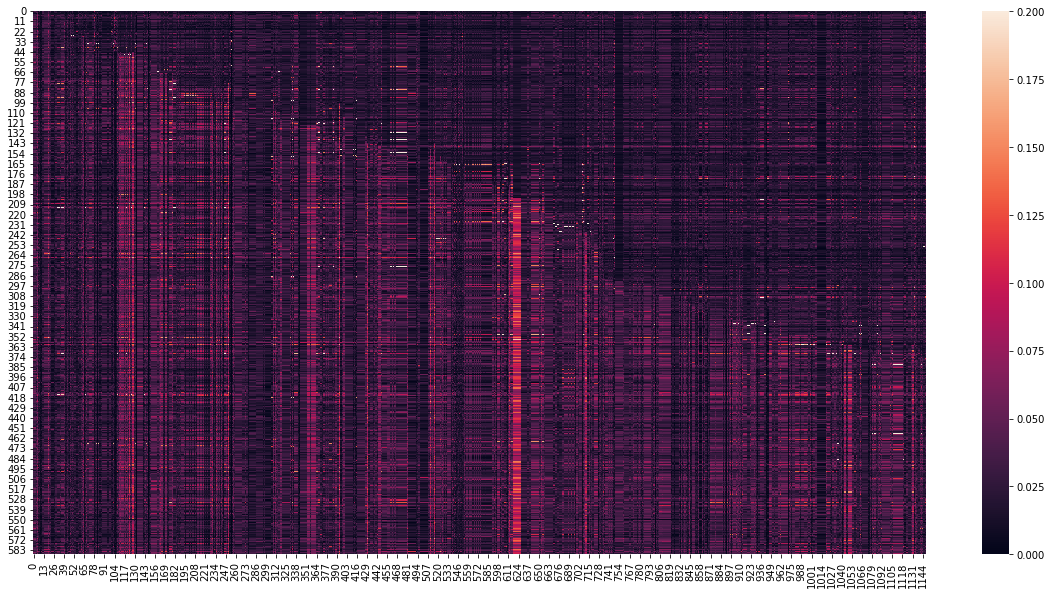

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(np.clip(mtx_fox_fla, a_min=0.0, a_max=0.2), vmin=0.0, vmax=0.2)

<AxesSubplot:>

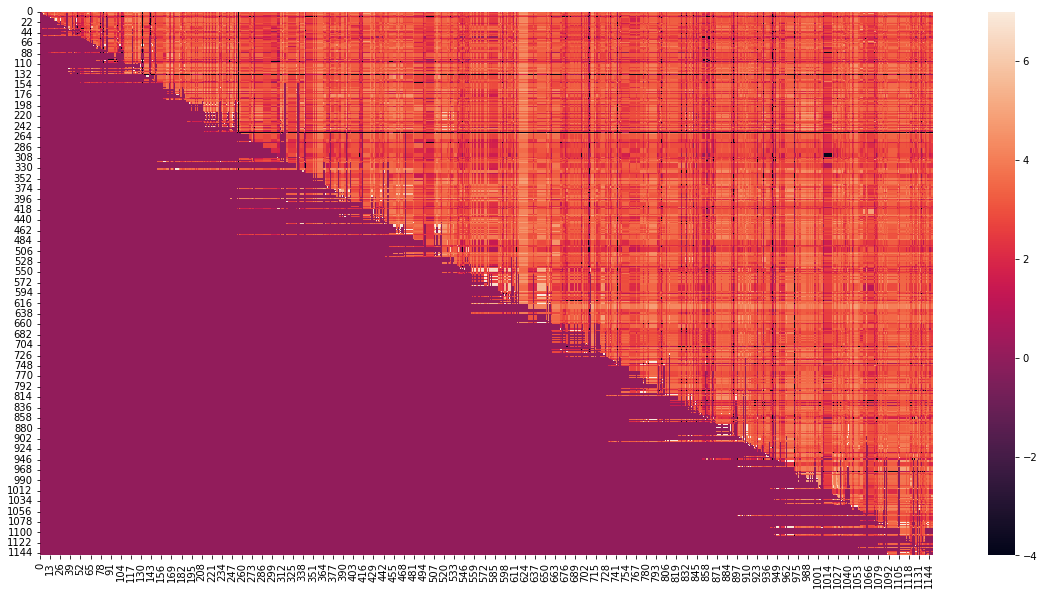

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(mtx_fla_fla, vmin=-4, vmax=7)

<AxesSubplot:>

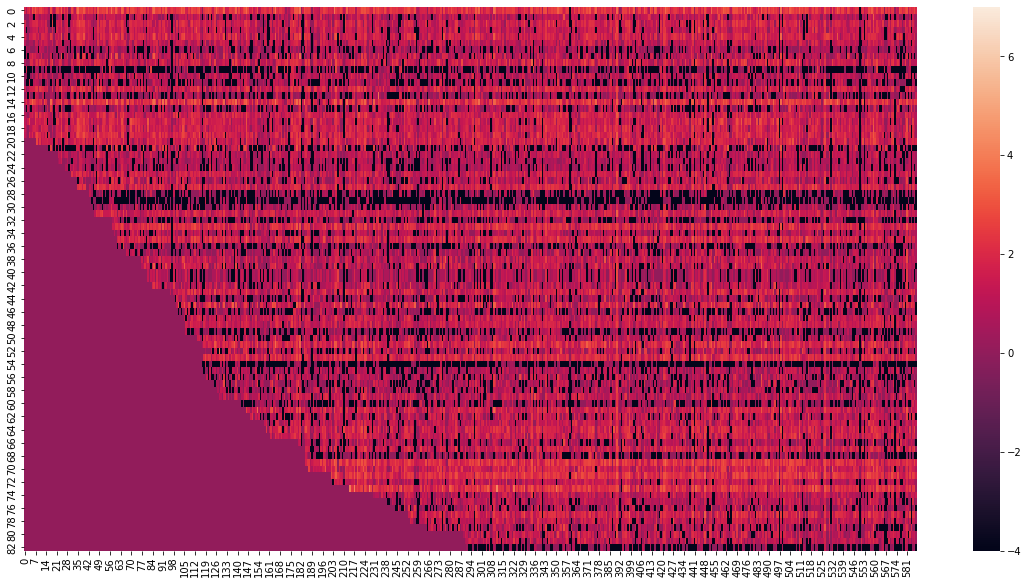

In [171]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(mtx_nyt_fox[:380, :], vmin=-4, vmax=7)